# Importaçao de bibliotecas

In [ ]:
import numpy as np
import cv2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

from matplotlib import pyplot as plt

In [ ]:
!git clone https://github.com/TarcizioLafaiete/Faraday

Cloning into 'Faraday'...
remote: Enumerating objects: 19998, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 19998 (delta 0), reused 3 (delta 0), pack-reused 19995
Receiving objects: 100% (19998/19998), 47.53 MiB | 33.08 MiB/s, done.
Checking out files: 100% (20001/20001), done.


# Pre-processamento de Imagem

## Funcoes auxiliares de pre-processamento

In [ ]:
#Funcao converte um inteiro em uma string de 6 digitos
def integerToString(integer):
    string = str(integer)
    while len(string) < 6:
      string = '0' + string
    return string

In [ ]:
#Funcao converte um caractere em uma posicao do vetor de 37 posicoes
def indexChar(char):
  if char >= 'A' and char <= 'Z':
    return ord(char) - 65
  elif char == '?':
    return 36
  else:
    return ord(char) - 48 + 26

## Captura dos sets de treino, validacao e teste

Não foi necessário realizar pré-processamentos nas imagens de entradas tendo em vista que o dataset fornecido era bem comportado e possuia todas as imagens com o mesmo tamanho, por exemplo.

No geral as imagens foram dividas em matrizes de 4 dimensões sendo a primeira dimensão o número de imagens e as outras 3 as dimensões da imagem

In [ ]:
trainImg = np.zeros((8000,50,180,1))
validImg = np.zeros((1000,50,180,1))
testImg = np.zeros((1000,50,180,1))

folderName = 'Faraday/dados/CAPTCHA-10k/'
typeOfFolder = 'treinamento/'
number = '000001'
typeFile = '.jpg'

#Dataset de treino
for i in range(1,8001,1):
  number = integerToString(i)
  name = str(folderName) + str(typeOfFolder) +str(number) + str(typeFile)
  img = cv2.imread(name,cv2.IMREAD_GRAYSCALE)
  img = img/255.0
  trainImg[i-1,:,:,0] = img

typeOfFolder = 'validacao/'
#Dataset de validacao
for i in range(8001,9001,1):
  number = integerToString(i)
  name = str(folderName) + str(typeOfFolder) +str(number) + str(typeFile)
  img = cv2.imread(name,cv2.IMREAD_GRAYSCALE)
  img = img/255.0
  validImg[i-8001,:,:,0] = img

typeOfFolder = 'teste/'
#Dataset de Teste
for i in range(9001,10000,1):
  number = integerToString(i)
  name = str(folderName) + str(typeOfFolder) +str(number) + str(typeFile)
  img = cv2.imread(name,cv2.IMREAD_GRAYSCALE)
  img = img/255.0
  testImg[i-9001,:,:,0] = img

## Captura dos labels 

Nos labels eles foram salvos em uma matriz de 3 dimensões, sendo a primeira de tamanho 6 correspondendo aos 6 caracteres do Captcha, a segunda dimensão é o número de labels do dataset e por fim a uma dimensão de tamanho 37 que corresponde as 26 possibilidades de letra, 10 digitos númericos e um com '?' que foi encontrado em alguns labels.


In [ ]:
Captchalabels = np.zeros((6,10000,37))

typeOfFolder = 'labels10k/'
typeFile = '.txt'
#Captura de labels
for j in range(1,10000,1):
  number = integerToString(j)
  name = str(folderName) + str(typeOfFolder) +str(number) + str(typeFile)
  label = open(name,"r")
  target = np.zeros((6,37))
  for n in range(6):
    char = label.read(1)
    index = indexChar(char)
    target[n,index] = 1
  Captchalabels[:,j-1,:] = target
#Divisao dos labels entre labels de treino,validacao e teste
trainLabel = Captchalabels[:,0:8000,:]
validLabel = Captchalabels[:,8000:9000,:]
testLabel = Captchalabels[:,9000:,:]

# Arquitetura de Rede

A arquitetura de rede utilizada consiste em 4 camadas de covulução seguidas de um MaxPooling com kerneis de 5x5 e com o número de filtros dobrando a cada nova covulução sendo a primeira iniciada com 8 filtros. Após as quatro camadas de covolução é realiza uma batch normalization e mais um pooling antes de realizar a linearização.

Com o vetor gerado na linearização passamos eles por 6 redes neurais full-connected em que cada uma tem uma camada de 64 neurônios, um dropout de 0.5 e por fim mais uma camada com 37 neuronios.

## Convulação

In [ ]:
from keras.layers.merging.concatenate import Concatenate
Concatenate,
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.engine import input_layer
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks

# Primeira convolução
sh = layers.Input(shape=(50,180,1))
conv1 = layers.Conv2D(8,(5,5),strides=1,padding='same',activation='relu')(sh)
mp1 = layers.MaxPooling2D(padding='same')(conv1)
# Segunda convolução
conv2 = layers.Conv2D(16,(5,5),strides=1,padding='same',activation='relu')(mp1)
mp2 = layers.MaxPooling2D(padding='same')(conv2)
# Terceira convolução
conv3 = layers.Conv2D(32,(5,5),strides=1,padding='same',activation='relu')(mp2)
mp3 = layers.MaxPooling2D(padding='same')(conv3) 
# Quarta convolução
conv4 = layers.Conv2D(64,(5,5),strides=1,padding='same',activation='relu')(mp3)
mp4 = layers.MaxPooling2D(padding='same')(conv4)
# Batch Normalization
bc = layers.BatchNormalization()(mp4)
mp5 = layers.MaxPooling2D(padding='same')(bc)
# Linearização
flat = layers.Flatten()(mp3)

## Full Connected neural network

In [ ]:
# FCNN do primeiro caractere
fc1 = layers.Dense(64, activation='relu')(flat)
fc1 = layers.Dropout(0.5)(fc1)
fc1 = layers.Dense(37,activation='sigmoid')(fc1)
# FCNN do segundo caractere
fc2 = layers.Dense(64, activation='relu')(flat)
fc2 = layers.Dropout(0.5)(fc2)
fc2 = layers.Dense(37,activation='sigmoid')(fc2)
# FCNN do terceiro caractere
fc3 = layers.Dense(64, activation='relu')(flat)
fc3 = layers.Dropout(0.5)(fc3)
fc3 = layers.Dense(37,activation='sigmoid')(fc3)
# FCNN do quarto caractere
fc4 = layers.Dense(64, activation='relu')(flat)
fc4 = layers.Dropout(0.5)(fc4)
fc4 = layers.Dense(37,activation='sigmoid')(fc4)
# FCNN do quinto caractere
fc5 = layers.Dense(64, activation='relu')(flat)
fc5 = layers.Dropout(0.5)(fc5)
fc5 = layers.Dense(37,activation='sigmoid')(fc5)
# FCNN do sexto caractere
fc6 = layers.Dense(64,activation= 'relu')(flat)
fc6 = layers.Dropout(0.5)(fc6)
fc6 = layers.Dense(37,activation = 'sigmoid')(fc6)

## Criação de Modelo

In [ ]:
model = Model(sh,[fc1,fc2,fc3,fc4,fc5,fc6])
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary();


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 180, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 180, 8)   208         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 90, 8)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 90, 16)   3216        ['max_pooling2d[0][0]']      

# Treinamento

In [ ]:
history = model.fit(trainImg,[trainLabel[0],trainLabel[1],trainLabel[2],trainLabel[3],trainLabel[4],trainLabel[5]],
                    epochs=90,batch_size = 32,validation_data=(validImg,[validLabel[0],validLabel[1],validLabel[2],validLabel[3],validLabel[4],validLabel[5]]))

Epoch 1/90
250/250 [==============================] - 88s 342ms/step - loss: 20.2043 - dense_1_loss: 3.3947 - dense_3_loss: 3.3837 - dense_5_loss: 3.3346 - dense_7_loss: 3.3151 - dense_9_loss: 3.3702 - dense_11_loss: 3.4060 - dense_1_accuracy: 0.0776 - dense_3_accuracy: 0.0814 - dense_5_accuracy: 0.0938 - dense_7_accuracy: 0.0876 - dense_9_accuracy: 0.0856 - dense_11_accuracy: 0.0698 - val_loss: 13.7155 - val_dense_1_loss: 2.2771 - val_dense_3_loss: 2.3460 - val_dense_5_loss: 2.2495 - val_dense_7_loss: 2.0786 - val_dense_9_loss: 2.2177 - val_dense_11_loss: 2.5467 - val_dense_1_accuracy: 0.3940 - val_dense_3_accuracy: 0.3600 - val_dense_5_accuracy: 0.4110 - val_dense_7_accuracy: 0.4200 - val_dense_9_accuracy: 0.4020 - val_dense_11_accuracy: 0.2910
Epoch 2/90
250/250 [==============================] - 81s 325ms/step - loss: 12.2590 - dense_1_loss: 2.0055 - dense_3_loss: 1.9918 - dense_5_loss: 1.9828 - dense_7_loss: 1.9071 - dense_9_loss: 2.0970 - dense_11_loss: 2.2747 - dense_1_accuracy:

# Analise e Testes da Rede

## Funcoes auxiliares

In [ ]:
#Funcao procura a posicao do valor máximo no vetor de saída 
def returnPosition(res):
  max = 0
  pos = 0
  for i in range(37):
    if max < res[0,i]:
      max = res[0,i]
      pos  = i
  return pos
#Funcao converte a posicao no vetor de saída da rede no caractere correspondente
def convertToLetter(solution):
  string = ''
  print(solution)
  for i in range(6):
    if solution[i] <= 25:
      string = string + chr(65+solution[i])
    elif solution[i] == 36:
      string = string + '?'
    else:
      string = string + chr(48 - 26 + solution[i])
  return string


## Predição de novos Captchas

In [ ]:
# Teste da rede neural na predicao de Captchas
solution = np.zeros((6,50),dtype=(np.int64))
for i in range(50):
  pred = model.predict(testImg[i:i+1,:,:,0])
  res = pred[0]
  solution[0,i] = returnPosition(res)
  res = pred[1]
  solution[1,i] = returnPosition(res)
  res = pred[2]
  solution[2,i] = returnPosition(res)
  res = pred[3]
  solution[3,i] = returnPosition(res)
  res = pred[4]
  solution[4,i] = returnPosition(res)
  res = pred[5]
  solution[5,i] = returnPosition(res)


1/1 [==============================] - 0s 25ms/step


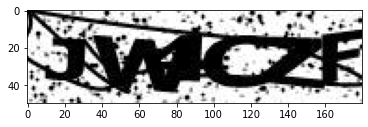

[ 9 22 30  2 25  5]
JW4CZF


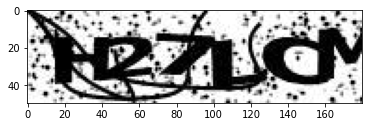

[ 7 28 33 11  2 12]
H27LCM


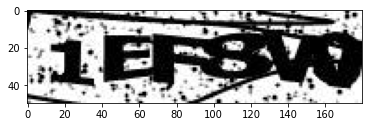

[27  4  5 34 22 26]
1EF8W0


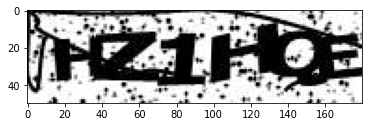

[ 7 25 27  7 16  4]
HZ1HQE


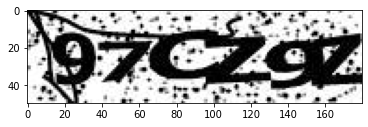

[35 33  2 25 35 25]
97CZ9Z


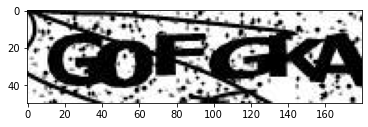

[ 6 14  5  6 10  0]
GOFGKA


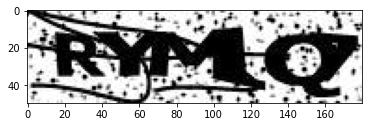

[17 24 12 27 16 33]
RYM1Q7


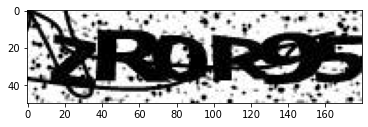

[25 17 26 17 35 31]
ZR0R95


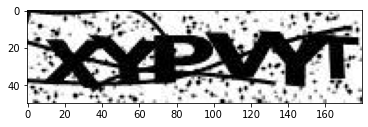

[23 24 15 21 24 19]
XYPVYT


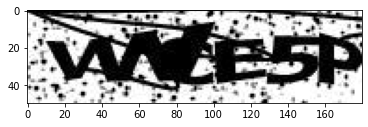

[21 22 27  4 31 15]
VW1E5P


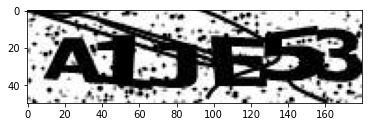

[ 0 27  9  4 31 29]
A1JE53


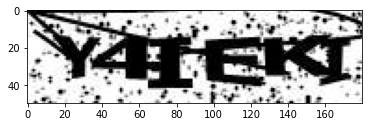

[24 30  8  4 10 19]
Y4IEKT


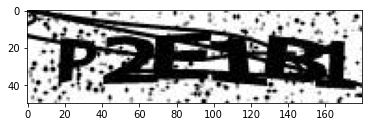

[15 28  4 27  1 27]
P2E1B1


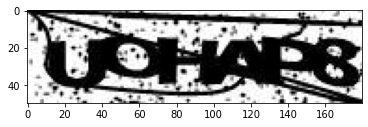

[20 14  7  0 15 34]
UOHAP8


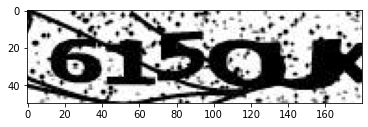

[32 27 31 14 20 23]
615OUX


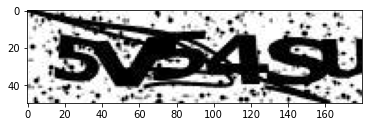

[31 21 31 30 18 20]
5V54SU


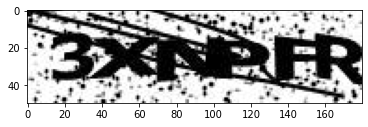

[29 23 13 15  5 17]
3XNPFR


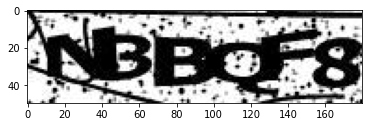

[13  1  1 16  5 34]
NBBQF8


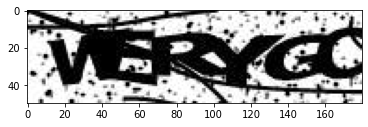

[22  4 17 24  6  2]
WERYGC


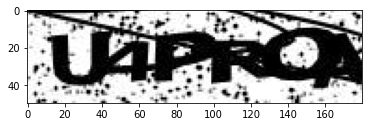

[20 30 15 17 14  0]
U4PROA


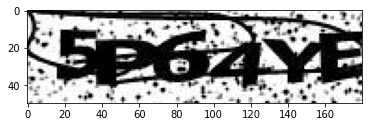

[31 15 32 30 24  4]
5P64YE


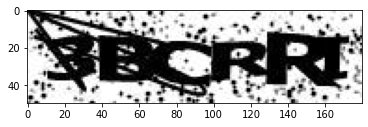

[29  1  2 17 17  8]
3BCRRI


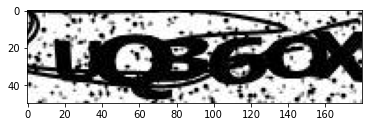

[20 16 29 32 14 23]
UQ36OX


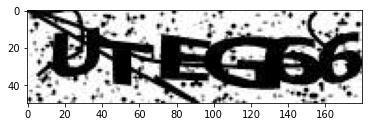

[20 19  4  6 32 32]
UTEG66


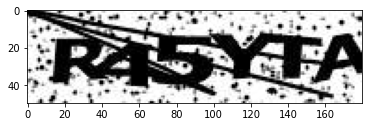

[17 30 31 24 19  0]
R45YTA


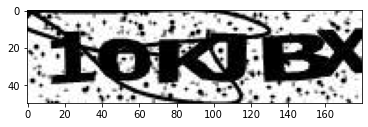

[27 26 10  9  1 23]
10KJBX


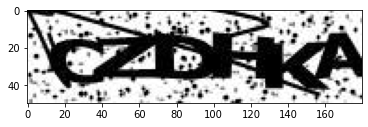

[ 2 25  3  7 10  0]
CZDHKA


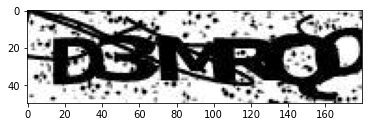

[ 3 29 12 17 16 14]
D3MRQO


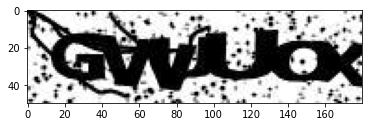

[ 6 22 20 20 14 10]
GWUUOK


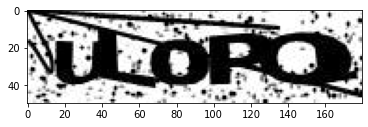

[20 11 26 15 14 27]
UL0PO1


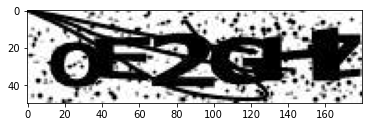

[14  4 28  6  7 25]
OE2GHZ


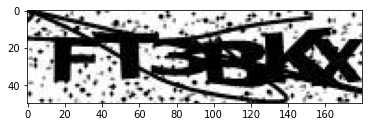

[ 5 19 29  1 10 23]
FT3BKX


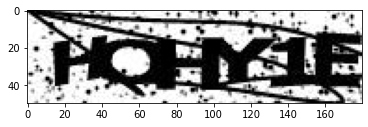

[ 7 14  7 24 27  4]
HOHY1E


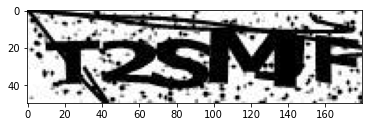

[19 28 18 12 27  5]
T2SM1F


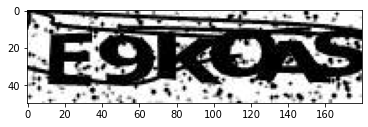

[ 4 35 10 14  0 18]
E9KOAS


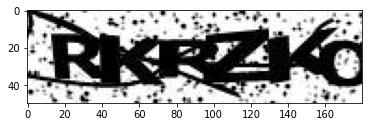

[17 10 17 25 10 14]
RKRZKO


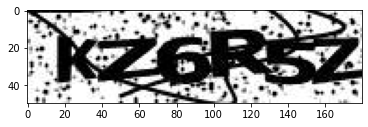

[10 25 32 17 31 25]
KZ6R5Z


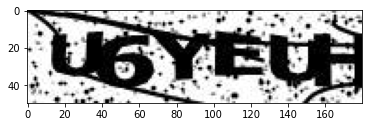

[20 32 21  4 20  7]
U6VEUH


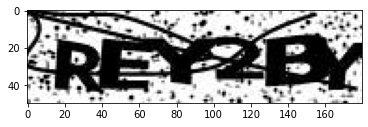

[17  4 24 28  1 24]
REY2BY


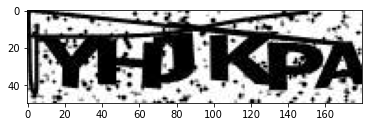

[21  7  9 10 15  0]
VHJKPA


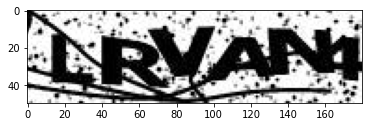

[11 17 21  0 13 30]
LRVAN4


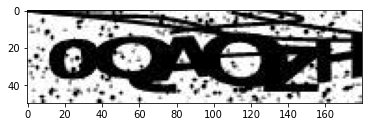

[26 14  0 14 33  7]
0OAO7H


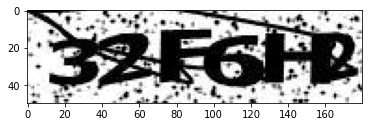

[29 28  5 31  7 28]
32F5H2


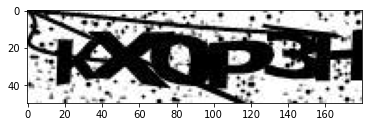

[10 23 26 15 29  7]
KX0P3H


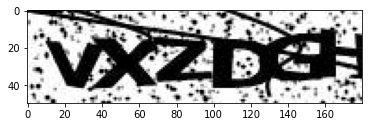

[21 23 25  3  6  7]
VXZDGH


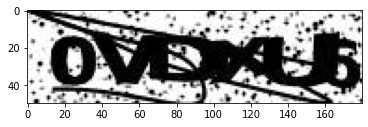

[26 21  3 23 20 32]
0VDXU6


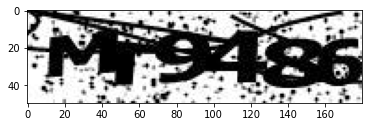

[12 19 35 30 34 32]
MT9486


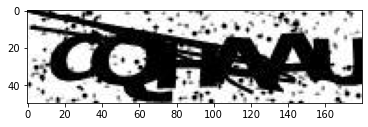

[ 2 14  7  0  0 20]
COHAAU


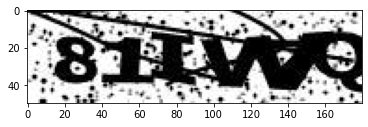

[ 1 27  8 22 33 14]
B1IW7O


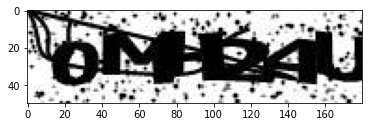

[26 12  7 28 30 20]
0MH24U


In [ ]:
#Comparacao entre a imagem e a string predita pela rede
for i in range(50):
  plt.imshow(testImg[i,:,:,0]*255, cmap = 'gray', clim=(0, 255))
  plt.show()
  string = convertToLetter(solution[:,i])
  print(string)

## Resultados

In [ ]:
correct = np.zeros((6))
chrCorrect = 0
for i in range(50):
  for j in range(6):
    chrCorrect = chrCorrect + testLabel[j,i,solution[j,i]]
  for l in range(6):
    if l < chrCorrect:
      correct[l] = correct[l] + 1
  chrCorrect = 0
print(correct)

[50. 50. 50. 50. 47. 36.]


## Taxa de reconhecimento

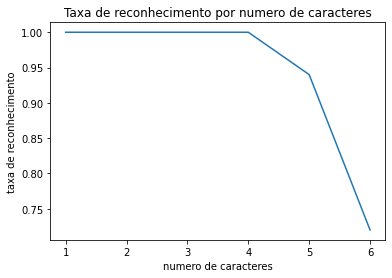

In [ ]:
tax = correct/50
plt.plot([1,2,3,4,5,6],tax)
plt.xlabel('numero de caracteres')
plt.ylabel('taxa de reconhecimento')
plt.title('Taxa de reconhecimento por numero de caracteres')
plt.show()